<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI 3D Object Detection - LiDAR**

In this tutorial we will dive into the KITTI dataset and detect objects in 3D using camera images to detect objects in 2D and LiDAR point cloud data to provide the depth info to give us a 3D perspective of the detected objects. Detection in 3D as opposed to 2D is much more useful to an autonomous vehicle since 3D detection let's the system know where objects located in the world.

<br>

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf). 

<br>

Now let's get the data and get started.

# **TO DO**
- Check notation and code for consistency &#8594; Revert to $T_a^b$ or T_a_b where coordinate system a is transformed to coordinates system b by the transformation matrix $T$.
- Finish docuementing sanity checks
- Ensure Video is produced
- Proofread and Code Clean

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-09-13 22:48:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.197
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  43.0MB/s    in 67s     

2022-09-13 22:49:46 (44.3 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-09-13 22:49:47--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.140.31
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.140.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-09-13 22:49:47 (157 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Base Library Import

In [4]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Import KITTI Utility functions

In [5]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

--2022-09-13 22:50:01--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2022-09-13 22:50:02--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8742 (8.5K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   8.54K  --.-KB/s    in 0s      

2022-09-13 22:50:02 (78.6 MB/s) - ‘kitti_utils.py’ saved [8742/8742]



## Data Overview

In the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system. 

The update rates are as follows:
- RGB camera: 15 Hz (15 fps)
- OXTS GPS navigation system: 100Hz
- Velodyne LiDAR: 10Hz 

The data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera, GPS/IMU (navigation), and LiDAR is not precise (even though we are using the synched raw data!). Per the KITTI [description](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) the worst time difference between the camera/velodyne and gps/imu is at most 5ms. More precise measurements can be obtained with interpolation, but for simplicity we will neglect these differences since the small error from the imprecise sync will not greatly impact our measurements. We will see later when we project LiDAR points onto the camera images, that there is no noticable difference.

<br>
<br>


Now let's get the paths to all of the datafiles, the RGB images are standard .png's, the Navigation frames are .txt files, but the LiDAR point clouds are binary files. The [KITTI README](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT) describes the structure of the binary files, and we will import a utility function to handle them.

In [6]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


## **Camera/LiDAR/IMU Data**

In order to obtain an understanding of the code to follow, it will help to cover the different reference frames that we will be working with and how we can convert between them. The Camera, LiDAR, and IMU are located at different positions on the vehicle and all have different reference frame.

- camera
  - x &#8594; right
  - y &#8594; down
  - z &#8594; forward
- LiDAR
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up

- IMU
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up




  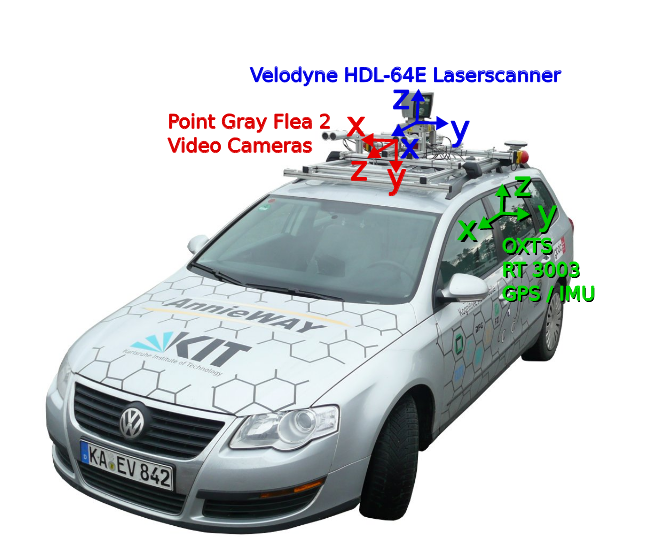

## **LiDAR to Camera**

In order to convert a point from the LiDAR to the camera, we must perform three transformations on the point.

The first transformation converts the point to the LiDAR frame of reference via [rigid body transformation](https://www.seas.upenn.edu/~meam620/slides/kinematics0.pdf), which takes into account the rotation and translation of the axes. A rigid transformation has two main componenents a rotation and a translation. A rigid transformation matrix can combine these two components like so:

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\ 
            r_{21} & r_{22} & r_{23} & t_{24} \\ 
            r_{31} & r_{32} & r_{33} & t_{34} 
        \end{bmatrix}
$$

Where the r's correspond to the 3x3 rotation matrix and the t's correspond to the 3x1 translation vector.

Next we perform the [rectifying transformation](https://en.wikipedia.org/wiki/Image_rectification), which is just a rotation. We need the rectifying transformtion since we are working the stereo images that are referenced to the same y-axis (i.e. an object on left image has the same y-coordinate as the right image, but not the necissarily the same x-coordinate). When a pair of stereo images are referenced to the same image plane (y-axis) we call them rectified.

Finally we apply the projection transformation on the point, which is another rigid body transformation. This gives us the location of a 3D point in 2D image space.

<br>

#### **LiDAR to Camera Summary**
We can combine these three transformation into a single transformation matrix that will perform the LiDAR to Camera tranformation in a single operation. The LiDAR to Camera translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space using the [homogeneous representation](https://en.wikipedia.org/wiki/Homogeneous_coordinates), where the $\tilde{}$ denotes a homogeneous vector.

$$ \tilde{y} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$

$$ \tilde{y} = \left( \tilde{u}, \tilde{v}, z, 1 \right) $$

For convenience we will denote:
$$ T^{uvz}_{velo} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} $$

Where (u,v,z) are the final camera coordinates after the rectification and projection transforms. In order to transform from homogeneous image coordinates $\tilde{y}$ to true (u, v, z) image coordinates y, we will need to normalize by the depth and drop the 1, like so:

$$ y = \left( \frac{\tilde{u}}{z}, \frac{\tilde{v}}{z}, z \right) $$

NOTE:
- The notation convention is that the starting refence frame is in the subscript and the ending reference frame is in the superscript
- The '1' added as the 4th coordinate in homogeneous representation is sometimes referred to as 'w'

We will opt to translate all points to the left image 

<br>
<br>

## **Camera to LiDAR**

To transform Camera (u,v,z) (where in this case z will be LiDAR depth in meters) we will need to follow a few steps.

First we need to convert $T^{uvz}_{velo}$ to it's homogeneous representation, we can do that by adding a row of new coordinates on the bottom, where 0's will be placed under the rotation portion and a 1 will be placed under the translation portion.

$$ T^{uvz}_{velo} = \begin{bmatrix}
                     t_{11} & t_{12} & t_{13} & t_{14} \\ 
                     t_{21} & t_{22} & t_{23} & t_{24} \\ 
                     t_{31} & t_{32} & t_{33} & t_{34} \\ 
                          0 &      0 &      0 & 1      \\ 
                    \end{bmatrix}
$$

Next we need to convert $y$ back to it's homogeneous form $\tilde{y}$

$$ \tilde{y} = (u \cdot z,\; v \cdot z,\; z,\; 1) $$

and finally we can get the homogeneous representation in LiDAR coordinates, by inverting the homogeneous transformation [matrix](http://www.info.hiroshima-cu.ac.jp/~miyazaki/knowledge/teche0053.html)


$$ 
\begin{align*}
    T^{velo}_{uvz} &= (T^{uvz}_{velo})^{-1}  \\
    T^{velo}_{uvz} \tilde{y} &= \tilde{x}
\end{align*}
$$

## **IMU to LiDAR**

We will also need to translate IMU to LiDAR, thankfully we have a single matrix $T^{velo}_{imu}$ that will handle this in a single operation.

$$y_{velo} = T^{velo}_{imu} x_{imu}$$

And once we have $y_{velo}$ we can convert it to camera coordiantes using the equations above, or we can compose the transformations:

$$ 
    T^{uvz}_{imu} = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} T^{velo}_{imu}
$$

To transform from the Camera to IMU coordiantes, we can do a very similar operation as we did for camera to LiDAR. We just use the homogeneous representation of the transformation matrix and take it's inverse, then we can invert the transform.

$$ 
\begin{align*}
    T^{imu}_{uvz} &= (T^{uvz}_{imu})^{-1}  \\
    T^{imu}_{uvz} \tilde{y}_{uvz} &=  \tilde{x}_{imu}
\end{align*}
$$

<br>
<br>

## **IMU to Geodetic**

To convert from IMU (x, y, z) coordinates to Geodetic  (Latitude, Longitude, Altitude (Height Above Ellipsoid - HAE)), we can follow these steps:
1. Convert IMU (x, y, z) to (Slant Range, Azimuth, Elevation)
2. Convert (Range, Azimuth, Elevation) to (Latitude, Longitude, HAE)

In step 1 we can convert the (x, y, z) to (Slant Range, Azimuth, Elevation) with 

$$  range = \sqrt{x^2 + y^2 + z^2} \\
    azimuth = tan^{-1}\left( \frac{y}{x} \right) \\
    elevation = tan^{-1} \left(\frac{\sqrt{x^2 + y^2}}{z} \right)
$$

We won't go through the details for step 2 here, we will use pymap3d to handle this.

## **Load Camera Calibration Data**


In [7]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_rect2lcam = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
# P_rect2rcam = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_ref2lrect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
# R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_ref2lrect = np.insert(R_ref2lrect, 3, values=[0,0,0], axis=0)
R_ref2lrect = np.insert(R_ref2lrect, 3, values=[0,0,0,1], axis=1)

## **Load LiDAR and GPS/IMU Calibration Data**

In [8]:
T_velo2ref = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu2velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

Obtain matrix to transform 3D LiDAR/velo (x, y, z) coordiantes to 2D camera (u,v) coordinates, and it's homogeneous inverse that will allow us to transform from camera (u, v, z, 1) back to LiDAR (x, y, z, 1)

In [9]:
# transform from velo (LiDAR) to left color camera
T_velo2lcam = P_rect2lcam @ R_ref2lrect @ T_velo2ref

# homogeneous transform from left color camera to velo (LiDAR)
T_lcam2velo = np.linalg.inv(np.insert(T_velo2lcam, 3, values=[0,0,0,1], axis=0)) 

Now we can get the transformation matrix for IMU to camera and cmaera to IMU

In [10]:
# transform from IMU to left color camera
T_imu2lcam = T_velo2lcam @ T_imu2velo

# homogeneous transform from left color camera to IMU
T_lcam2imu = np.linalg.inv(np.insert(T_imu2lcam, 3, values=[0,0,0,1], axis=0)) 

Now that we are able to project the LiDAR points onto the image, we can associate points on the image with LiDAR depth. We will use YOLOv5 to detect objects in 2D, then we will find their corresponding depths. Then using our GPS/IMU data we can find out where all of these objects are located in the world via Latitude and Longitude.

<br>

## **Get Object Detection Pipeline**

In [11]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12290, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 12290 (delta 0), reused 0 (delta 0), pack-reused 12287
Receiving objects: 100% (12290/12290), 12.63 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (8463/8463), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [13]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-13 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [14]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Detection Pipeline**

Now we can define the main pipeline to get the detections and their center coordinates in multiple reference frames. We will get the object centers in:
- Camera (u, v, z)
- LiDAR (x, y, z)
- IMU (x, y, z)


The basic pipeline is:

1. Detect objects in camera image
2. Project LiDAR point cloud to camera (u,v,z) coordinates
3. Associate object centers with projected (u,v,z) points
4. Transform (u,v,z) objects centers to IMU (x,y,z) coordinates
5. Transform IMU (x,y,z) coordinates to Lat/Lon/Alt

### **1. Detect Objects on image**
Using YOLOv5 out of the box this is a quick 1-liner!

```
detections = model(left_image)
```


### **2. Project LiDAR to (u,v,z)**
We will use a function from our KITTI utils script that will use our rotation matrix $T$ to project (convert) LiDAR (x,y,z) into camera (u,v,z). This function will also handle removing points that fall out of the Feild of View (FOV) of the camera. This function will also remove the ground plane from the LiDAR point cloud using the [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) algorithm in sklearn. RANAC essientially seeks to find the largest plane in the point cloud, and then we remove it.

### **3. Associate Detected Object Centers with (u,v,z) points**
To asscoiate the detected object centers with the (u,v,z) points we compare the [L2 norm](https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c) of the object bounding box center location to all projected LiDAR (u, v) points. Then we take the point with the smallest L2 norm.

In [15]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates. 
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])
        
        # add velo projectios (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return bboxes_out


In [16]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of 
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz 
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path, 
                                   T_velo2lcam, 
                                   left_image, 
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image, 
                             velo_uvz, 
                             bboxes, 
                             draw=draw_depth)

    return bboxes, velo_uvz

### **4. Transform (u,v,z) objects centers to IMU (x,y,z) coordinates**

To transform the (u,v,z) object centers, we just convert them to homogeneous and use our homogeneous transformation to get the IMU (x,y,z) coordinates.

In [17]:
def transform_uvz(uvz, T):
    ''' Transforms the uvz coordinates to xyz coordinates. The xyz coordinate
        frame is specified by the transformation matrix T. The transformation
        may include:
            uvz -> xyz (LiDAR)
            uvz -> xyz (IMU)

        Inputs: uvz (Nx3) array of uvz coordinates
        Outputs: xyz (Nx3) array of xyz coordinates
        '''
    # covnert to homogeneous representation
    uvzw = np.hstack((uvz[:, :2] * uvz[:, 2][:, None], 
                      uvz[:, 2][:, None],
                      np.ones((len(uvz[:, :3]), 1))))
    
    # perform homogeneous transformation
    xyzw = T @ uvzw.T
    
    # get xyz coordinates
    xyz = xyzw[:3, :].T

    return xyz

### **5 Convert IMU to LLA**
Now we need to convert the object IMU (x, y, z) coordinates to Azimuth, Elevation, and Range. Then we can use pymap3d to convert the object centers to Latitude, Longitude, and Altitude. TThe altitude the KITTI dataset does not specify what type of altitude, but the [OXTS documentation](https://www.oxts.com/wp-content/uploads/2020/03/rtman-200302.pdf) states that it can measure either geoidal (MSL) or ellipsoidal (HAE), for details see [this](https://support.pix4d.com/hc/en-us/articles/202559869-Orthometric-vs-ellipsoidal-height). We will go ahead and assume that altitude doesn't matter

In [18]:
!pip install pymap3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.1 MB/s 


In [102]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current 
        location. This function works with x,y,z as vectors and lat0, lon0, 
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of 
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90 
    
    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

#### **Test the pipeline**

In [107]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# velo_xyz = transform_uvz(uvz, T_lcam2velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_lcam2imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [104]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

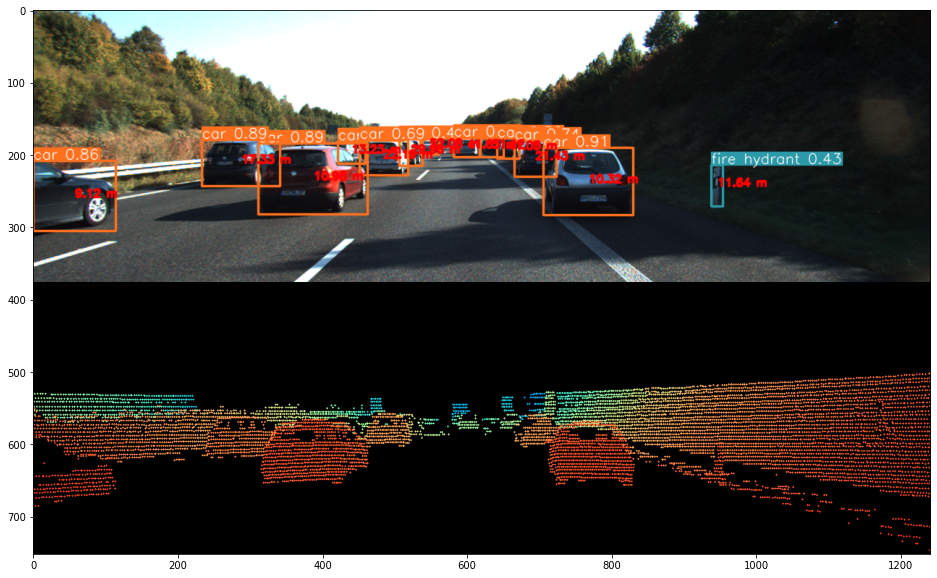

In [105]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

## **Sanity Checks**

Now that we have the (x, y, z) locations for the detected objects in multiple reference frames, we should perform some sort of sanity checks to ensure that we have correctly implemented the transformations described at the beginning of this notebook. We don't have any truth data for the detected objects, but we do have camera images that we can spot check. The first thing we can do is make note of the (u,v,z) positions, specifcially the z position which is the depth relative to the left color camera. 

In [31]:
uvz

array([[     766.68,      237.29,      10.315],
       [     288.56,      211.99,      17.327],
       [     388.25,      235.32,      10.978],
       [     58.869,      260.94,      9.1234],
       [     693.71,      205.87,      21.433],
       [     484.93,      204.75,      22.193],
       [     656.75,       193.1,      41.051],
       [     599.83,      193.87,      41.629],
       [     522.15,         197,      29.957],
       [     947.36,      242.32,      11.645],
       [     438.54,      200.23,      13.229],
       [     549.14,      190.42,       52.08],
       [     634.45,      189.21,      51.124]])

We can relate the (u, v) pixel locations and z depths to the objects in the image and spot check for correctness. Now we can spot check our rotation from Camera to IMU. We can look at the diagram (INSERT IMAGE FROM PAPER) and see that the IMU is #### meters behind the camera. So the $x_{imu}$ value in the imu coordinate frame should be equal to $x_{imu} + z_{cam2} + XXXX$. Remember the depth axis in the IMU coordinate frame is different than that of the camera coordiant frame.

In [32]:
imu_xyz

array([[     11.421,     -2.4936,   -0.050438],
       [      18.38,      7.5127, -0.00085792],
       [     12.054,      3.1421,   -0.081268],
       [     10.179,      6.7471,    -0.27394],
       [     22.541,     -2.7248,    0.025488],
       [     23.267,      3.6335,    0.023759],
       [     42.161,     -2.8694,     0.09292],
       [     42.722,     0.38954,    0.033466],
       [     31.032,      3.4446,    0.096847],
       [     12.768,     -5.7086,    -0.22952],
       [     14.308,      2.9149,     0.39659],
       [     53.152,      4.2251,    0.098498],
       [      52.23,     -1.9237,     0.20653]])

Finally we can compare locations on the image with the $y_{imu}$ locations and spot check it for correctness.

Now that we have locations for each object we can recontsruct the scene at each frame, using the LLA locations.

In [23]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import folium

drive_map = folium.Map(
    location=(lat0, lon0), # starting location
    zoom_start=15
)

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [25]:
# place the position of each detection on the map
for pos in lla:
    folium.CircleMarker(location=(pos[0], pos[1]),
                        radius=2,
                        weight=5,
                        color='green').add_to(drive_map);

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [26]:
drive_map

Now we can use opencv2 to display the environment detected by the Camera and LiDAR. In this case we will draw a rectangle for every detected onbject, but you can use the detected MSCOCO class in bboxes and draw custom sybmols for each different object. You could also cluster the data in LiDAR space and draw sybols based on the clustered data shape.

In [92]:
canvas_height = stacked.shape[0]
canvas_width = 500

In [93]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# get center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# cv2.circle(canvas, ego_center, 5, (0, 255, 0), -1);

# get rectangle coordiantes
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

In [94]:
# scale factor for nicer display
sf = 12
for val in imu_xyz:
    obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                  ego_center[1] - sf*int(np.round(val[0])))
    # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

    # get object rectangle coordinates
    obj_x1 = obj_center[0] - 5
    obj_y1 = obj_center[1] - 10
    obj_x2 = obj_center[0] + 5
    obj_y2 = obj_center[1] + 10

    cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);

In [109]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas


    

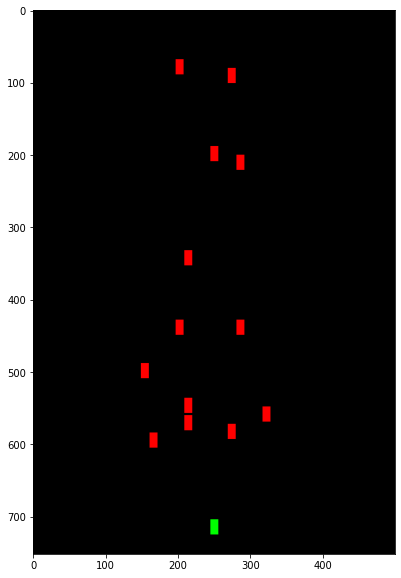

In [95]:
plt.imshow(canvas)

Now we stack all of the images together into a single frame!

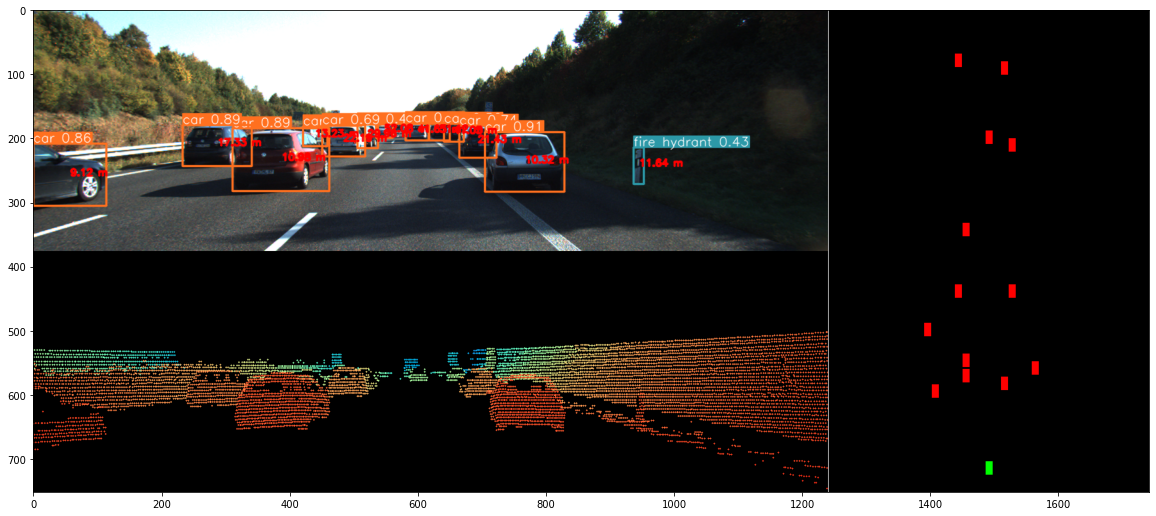

In [101]:
frame = np.hstack((stacked, 
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);

## **Video of Results**

Now we can make a video of our results

In [113]:
result_video = []

for index in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]
    oxts_frame = get_oxts(oxts_paths[index])

    # get detections and object centers in uvz
    bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

    # get transformed coordinates
    uvz = bboxes[:, -3:]

    # velo_xyz = transform_uvz(uvz, T_lcam2velo) # we can also get LiDAR coordiantes
    imu_xyz = transform_uvz(uvz, T_lcam2imu)

    # draw velo on blank image
    velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

    # stack frames
    stacked = np.vstack((left_image, velo_image))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    draw_scenario(canvas, imu_xyz, sf=12)
    
    # place everything in a single frame
    frame = np.hstack((stacked, 
                       255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                       canvas))

    # add to result video
    result_video.append(frame)

    if index==2:
        break

# get width and height for video frames
# h, w, _ = frame.shape

# out = cv2.VideoWriter('3dboxed_pointcloud_stack_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
# for i in range(len(result_video)):
#     out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
# out.release()

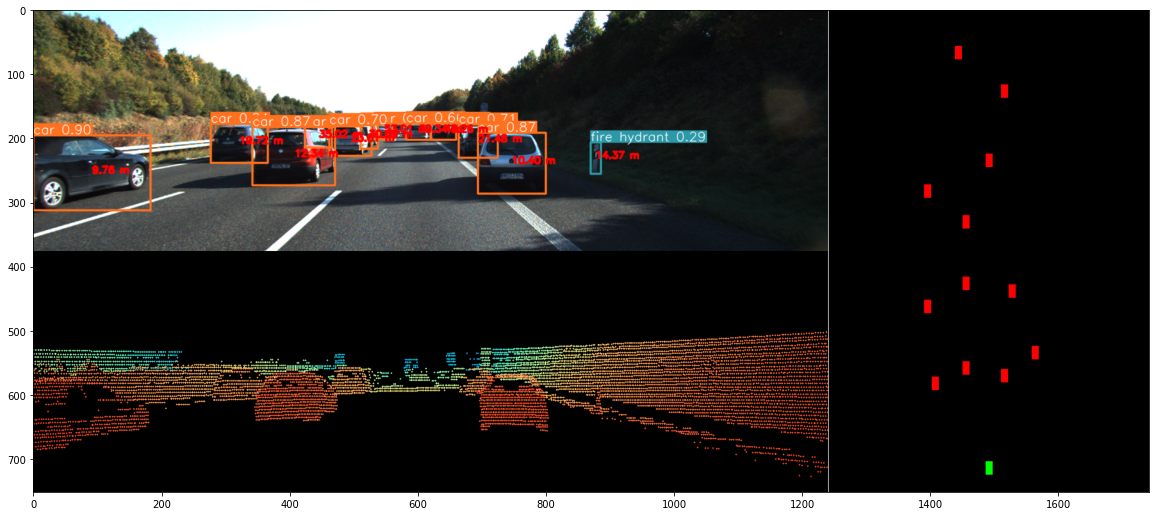

In [114]:
plt.imshow(frame)

In [112]:
index

20